# Detecting whether pairs of genomes and contaminants occur more than would be expected by chance

## Idea

Can we detect whether pairs of contaminants occur more often than would be expected by chance (like are the majority of *F. prausnitzii* genomes contaminated with it’s friend *R. hominis*?). 

## Approach

1. **Estimate the liklihood that a contaminant occurs by chance.** For each species in GTDB, calculate the fraction of genomes in GTDB that are contaminated with that species. This will be the baseline proportion for that species occuring as a contaminant by chance.
2. **Estimate the observed proportion of genomes in each species that are contaminated with every other species.** 
3. **Test whether a species-contaminant pair occurs more often than would expected by chance.** Use a one (two?)-sample test of proportion to see whether the observed proportion of genomes within a species that are contaminated by a species is higher than was estimated to occur by chance.

## Edit -- probably a better approach:

+ Use co-occurence libraries from microbiology/ecology

## Thinking through input files

Does the information needed to do this readily exists, ideally from stage1 alone, or does it need to be created?

**From stage1 outputs:**

It looks like I could do this at the order level using either `*.contam_summary.json` or `*.contigs-tax.json`, which record the order of each contig within a genome.
I could post-process the `.matches.csv` file, which includes the genome name and its similarity to all genomes in the database, summarizing it to taxonomy and using this to identify species-species relationships. I think the `matches.csv` is the prefetch results though, so it would only be presence/absence of species, not proportion of overlap, given the potential and likelihood of double counting

**From stage2 outputs:**

I wasn’t really planning on making stage2 outputs for all of GTDB, so I’d rather not use these, but if I did, I could use `*hitlist.matches.yaml`
 or `*.matches.json`, which both record contaminant genome identifiers, lineages, and counts. I guess I could make stage2 outputs only up until the `@toplevel` `rule hitlist_make_contigs_matches` to make these files, which would avoid mashmap and a lot of the other “heavy lifting” in stage2.

In [2]:
setwd("..")

In [47]:
library(jsonlite)
library(purrr)
library(dplyr)
library(tidyr)
library(tibble)
library(cooccur)
library(visNetwork)
library(igraph)

## Order-level co-occurrence analysis

Adapted from tutorial at https://medium.com/analytics-vidhya/how-to-create-co-occurrence-networks-with-the-r-packages-cooccur-and-visnetwork-f6e1ceb1c523

In [11]:
read_contigs_tax <- function(contigs_tax_path){  
  json <- fromJSON(contigs_tax_path)
  contig_tax_all <- data.frame()
  for(i in 1:length(json)){
    contig_name <- names(json)[i]
    basepairs <- json[[i]][[1]]
    hashes <- json[[i]][[2]]
    if(length(json[[i]][[3]]) > 0){
      lineage <- json[[i]][[3]][[1]][[1]][,2]
      lineage = paste(lineage, collapse = ";", sep = ";")
      matched_hashes <- json[[i]][[3]][[1]][[2]]
    } else {
      lineage = NA
      matched_hashes = NA
    }
    contig_tax <- data.frame(contig_name, basepairs, hashes, lineage, matched_hashes)
    contig_tax_all <- bind_rows(contig_tax_all, contig_tax)
  }
   contig_tax_all$genome <- gsub(".contigs-tax.json", "", basename(contigs_tax_path))
   return(contig_tax_all)
}

In [12]:
contigs_tax <- Sys.glob("~/Downloads/output.ibd2/stage1/*contigs-tax.json") %>%
   map_dfr(read_contigs_tax)

In [14]:
head(contigs_tax)

,contig_name,basepairs,hashes,lineage,matched_hashes,genome
,<chr>,<int>,<int>,<chr>,<int>,<chr>
1,ERS235530|10|k99_109,16725,13,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales,6,ERS235530_10.fna.gz
2,ERS235530|10|k99_178,3920,6,d__Bacteria;p__Firmicutes_A;c__Clostridia_A;o__Christensenellales,6,ERS235530_10.fna.gz
3,ERS235530|10|k99_533,4687,4,NA,NA,ERS235530_10.fna.gz
4,ERS235530|10|k99_718,3107,4,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales,4,ERS235530_10.fna.gz
5,ERS235530|10|k99_733,1008,1,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales,1,ERS235530_10.fna.gz
6,ERS235530|10|k99_768,4762,7,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales,7,ERS235530_10.fna.gz


In [15]:
contigs_tax <- contigs_tax %>% 
  group_by(genome, lineage) %>%
  summarize(matched_hashes = sum(matched_hashes)) 

`summarise()` has grouped output by 'genome'. You can override using the `.groups` argument.



In [33]:
# put genome across the top, lineages as rows
contigs_tax_pa <- contigs_tax %>%
  pivot_wider(id_cols = lineage, names_from = "genome", values_from = "matched_hashes") %>%
  filter(!is.na(lineage)) %>%
  column_to_rownames("lineage") %>%
  replace(is.na(.), 0) %>%
  mutate_if(is.numeric, ~1 * (. > 0))


In [34]:
contigs_tax_pa

,ERS235530_10.fna.gz,ERS235531_43.fna.gz,ERS235603_16.fna.gz,ERS396297_11.fna.gz,ERS396519_11.fna.gz,ERS473255_26.fna.gz,ERS537218_9.fna.gz,ERS537235_19.fna.gz,ERS537328_30.fna.gz,ERS537353_12.fna.gz,⋯,SRS1719498_9.fna.gz,SRS1719577_6.fna.gz,SRS1735506_4.fna.gz,SRS1735645_19.fna.gz,SRS294916_20.fna.gz,SRS476209_42.fna.gz,VatanenT_2016__G80445__bin.9.fa.gz,VogtmannE_2016__MMRS43563715ST-27-0-0__bin.70.fa.gz,XieH_2016__YSZC12003_37172__bin.63.fa.gz,ZeeviD_2015__PNP_Main_232__bin.27.fa.gz
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales,1,1,0,0,0,0,0,0,1,0,⋯,0,0,0,1,0,0,1,0,0,0
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales,1,0,1,1,1,0,0,1,0,1,⋯,1,0,1,1,0,1,0,0,0,1
d__Bacteria;p__Firmicutes_A;c__Clostridia_A;o__Christensenellales,1,1,0,0,1,0,1,0,1,0,⋯,0,0,0,1,0,0,0,0,0,0
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Eubacteriales,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,0,1,0,1
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,0,1,1,0,1,1
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales,1,1,1,1,1,0,0,0,0,0,⋯,1,0,0,1,1,0,0,0,0,0
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Saccharofermentanales,1,1,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__UBA1212,1,1,0,0,1,0,1,0,1,0,⋯,0,0,0,1,0,0,0,0,0,0


In [35]:
co <- print(cooccur(contigs_tax_pa, spp_names = TRUE))

  |======================================================================| 100%
Call:
cooccur(mat = contigs_tax_pa, spp_names = TRUE)

Of 325 species pair combinations, 235 pairs (72.31 %) were removed from the analysis because expected co-occurrence was < 1 and 90 pairs were analyzed

Cooccurrence Table:
   sp1 sp2 sp1_inc sp2_inc obs_cooccur prob_cooccur exp_cooccur    p_lt    p_gt
2    1   3       6      13           5        0.046         1.9 0.99962 0.00840
6    1   9       6       9           5        0.032         1.3 0.99998 0.00092
13   2   7      25      18          15        0.268        11.0 0.99870 0.01036
16   2  10      25      13          12        0.193         7.9 0.99970 0.00502
29   3   7      13      18           9        0.139         5.7 0.99512 0.02931
30   3   8      13       5           4        0.039         1.6 0.99828 0.02843
31   3   9      13       9           9        0.070         2.9 1.00000 0.00000
33   3  11      13      21          10        0.162  

- **sp1**: numeric indices for species 1
- **sp2**: numeric indices for species 2
- **p_lt**: if p_lt < 0.05, then the species pair co-occurs at a frequency lower than we would expect to find by chance
- **p_gt**: if p_gt < 0.05, the pair co-occurs at a rate higher than we would expect to find by chance

## Try visualization

In [37]:
# Create a data frame of the nodes in the network. 
nodes <- data.frame(id = 1:nrow(contigs_tax_pa),
                    label = rownames(contigs_tax_pa),
                    color = "#606482",
                    shadow = TRUE) 

In [39]:
# Create an edges dataframe from the significant pairwise co-occurrences.
edges <- data.frame(from = co$sp1, to = co$sp2,
                    color = ifelse(co$p_lt <= 0.05, "#B0B2C1", "#3C3F51"),
                                   dashes = ifelse(co$p_lt <= 0.05, TRUE, FALSE))

In [60]:
# plot with visNetwork and export interactive plot to html
# note visNetwork won't render in jupyter notebook, see alt plotting strategy below
visNetwork(nodes = nodes, edges = edges) %>%
  visIgraphLayout(layout = "layout_with_kk") %>%
  visExport(name = "network") %>%
  visSave(file = "tmp_network.html")

In [65]:
tmp <- graph_from_data_frame(edges, directed = F, vertices = nodes)

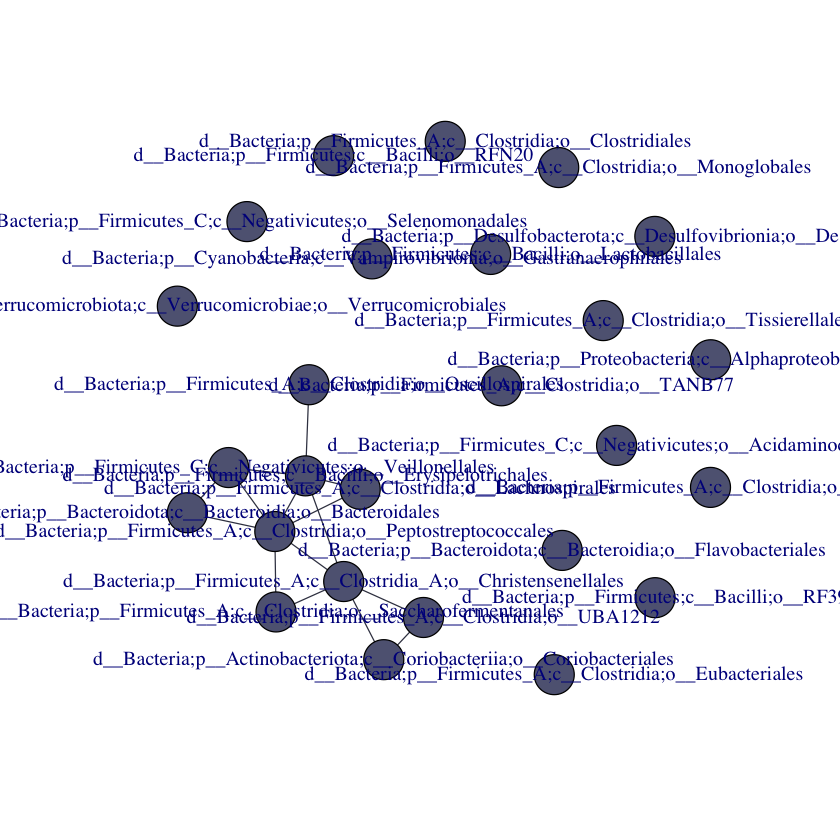

In [67]:
plot.igraph(tmp, )

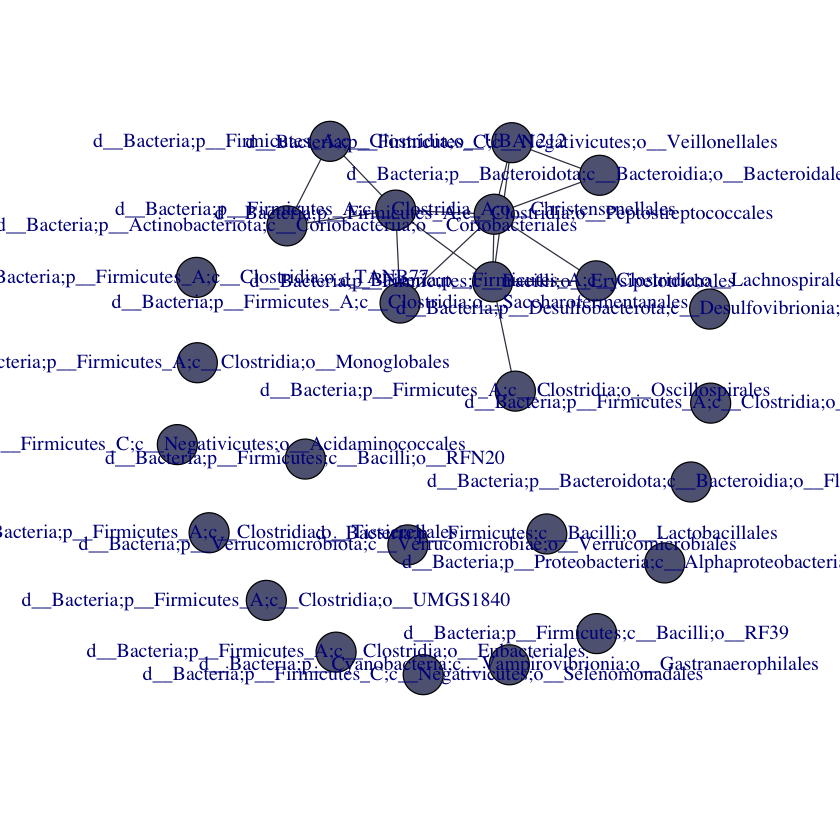

In [69]:
plot(tmp, layout=layout_with_kk)